# DocLayout-YOLO를 활용한 학습지 분석 시스템(LAM) - 수정버전

이 노트북은 DocLayout-YOLO를 활용하여 학습지 이미지의 레이아웃을 분석하는 시스템입니다.
모델에 내장된 클래스 레이블을 사용하며, 레이아웃 분석에 집중합니다.

## 주요 기능

1. 학습지 이미지의 레이아웃 분석 (DocLayout-YOLO)
2. 분석 결과 시각화
3. TSPM 연동을 위한 데이터 준비

## 실행 환경
- Google Colab
- Python 3.7+

In [ ]:
# 필요한 패키지 설치
print("🔧 환경 설정 중...")

# 기본 라이브러리 설치
!pip install -q numpy opencv-python matplotlib pillow tqdm

# Tesseract OCR 설치
!apt-get update
!apt-get install -q -y tesseract-ocr
!apt-get install -q -y tesseract-ocr-kor  # 한글 인식 데이터 설치
!pip install -q pytesseract

# DocLayout-YOLO 설치
!git clone https://github.com/opendatalab/DocLayout-YOLO.git
%cd DocLayout-YOLO
!pip install -q -e .

# API 연동을 위한 라이브러리 설치
!pip install -q requests

# 개선: 로깅 및 진행률 표시 라이브러리
!pip install -q loguru rich

print("✅ 모든 패키지 설치 완료!")

🔧 환경 설정 중...
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,765 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,742 kB]
Get:13 https://r2u.stat.illinois.ed


## 2. 필요한 라이브러리 임포트

In [ ]:
# 필요한 라이브러리 임포트
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import torch
import time
from PIL import Image
from google.colab import files
from doclayout_yolo import YOLOv10
from tqdm.notebook import tqdm

# 개선: 향상된 로깅 설정
from loguru import logger

# 로그 레벨 설정
logger.remove()
logger.add(sys.stderr, level="INFO")
logger.add("worksheet_analysis.log", rotation="10 MB", level="DEBUG")

2

## 3. 사전 훈련된 모델 다운로드 함수 정의

In [ ]:
def download_model(model_choice="doclaynet_docsynth"):
    """사전 훈련된 DocLayout-YOLO 모델 다운로드

    Args:
        model_choice (str): 사용할 모델 유형
            - "doclaynet_docsynth": DocLayNet + Docsynth300K (복잡한 학술 문서에 적합)
            - "docstructbench": Docsynth300K + DocStructBench (학습지에 권장)
            - "docsynth300k": DocSynth300K 사전훈련 모델 (커스텀 미세조정용)

    Returns:
        str: 다운로드된 모델 파일 경로
    """
    from huggingface_hub import hf_hub_download

    # 개선: 모델 선택 옵션 제공
    models = {
        "doclaynet_docsynth": {
            "repo_id": "juliozhao/DocLayout-YOLO-DocLayNet-Docsynth300K_pretrained",
            "filename": "doclayout_yolo_doclaynet_imgsz1120_docsynth_pretrain.pt"
        },
        "docstructbench": {
            "repo_id": "juliozhao/DocLayout-YOLO-DocStructBench",
            "filename": "doclayout_yolo_docstructbench_imgsz1024.pt"
        },
        "docsynth300k": {
            "repo_id": "juliozhao/DocLayout-YOLO-DocSynth300K-pretrain",
            "filename": "doclayout_yolo_docsynth300k_imgsz1600.pt"
        }
    }

    selected_model = models.get(model_choice, models["doclaynet_docsynth"])

    try:
        logger.info(f"다운로드 중: {selected_model['repo_id']} - {selected_model['filename']}")

        filepath = hf_hub_download(
            repo_id=selected_model["repo_id"],
            filename=selected_model["filename"]
        )

        logger.success(f"모델이 다운로드 되었습니다: {filepath}")
        return filepath
    except Exception as e:
        logger.error(f"모델 다운로드 중 오류 발생: {e}")
        raise

## 4. 이미지 업로드 및 전처리 컴포넌트

In [ ]:
def upload_and_prepare_image():
    """이미지 업로드 및 기본 시각화"""
    logger.info("이미지 업로드 대기 중...")

    try:
        # 이미지 업로드 기능
        uploaded = files.upload()

        # 업로드된 첫 번째 이미지 파일명 가져오기
        if not uploaded:
            logger.error("이미지가 업로드되지 않았습니다.")
            return None, None

        image_path = list(uploaded.keys())[0]
        logger.info(f"업로드된 이미지: {image_path}")

        # 이미지 로드 및 시각화
        img = cv2.imread(image_path)

        if img is None:
            logger.error(f"이미지를 로드할 수 없습니다: {image_path}")
            return None, None

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(12, 10), dpi=150)
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title('업로드된 학습지 이미지')
        plt.show()

        return image_path, img

    except Exception as e:
        logger.error(f"이미지 업로드 중 오류 발생: {e}")
        return None, None

## 5. 모델 로드 및 설정

In [ ]:
def load_model(model_path):
    """DocLayout-YOLO 모델 로드"""
    try:
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        logger.info(f"사용 중인 디바이스: {device}")

        # 중요: 추론 모드로만 모델 로드 (두 번째 매개변수로 task 지정)
        model = YOLOv10(model_path, task='predict')

        # 디바이스 설정
        model.to(device)

        # 주의: model.eval() 호출하지 않음
        # 대신 필요한 경우 직접 training 속성 설정
        if hasattr(model, 'training'):
            model.training = False

        return model, device

    except Exception as e:
        logger.error(f"모델 로드 중 오류 발생: {e}")
        raise

## 6. 레이아웃 분석 컴포넌트

In [ ]:
def analyze_layout(model, image_path, img, device='cpu', model_choice="doclaynet_docsynth"):
    """DocLayout-YOLO를 사용한 레이아웃 분석"""
    logger.info("레이아웃 분석 시작...")

    try:
        # 개선: 모델 유형에 따른 최적 이미지 크기 및 설정 자동 선택
        if model_choice == "docstructbench":
            imgsz = 1024
            conf = 0.25
        elif model_choice == "docsynth300k":
            imgsz = 1600  # DocSynth300K 모델 최적 크기
            conf = 0.15   # 사전훈련 모델은 낮은 신뢰도 임계값 사용
        else:  # doclaynet_docsynth
            imgsz = 1536
            conf = 0.20

        # 분석 결과 얻기
        results = model.predict(
            image_path,
            imgsz=imgsz,
            conf=conf,
            iou=0.45,
            device=device
        )

        # 감지된 영역 정보 추출
        boxes = results[0].boxes.xyxy.cpu().numpy()
        classes = results[0].boxes.cls.cpu().numpy()
        confs = results[0].boxes.conf.cpu().numpy()
        class_names = model.names

        # 모델 내장 클래스 이름 사용 (매핑 없이)
        logger.debug(f"모델이 인식한 클래스 이름: {class_names}")

        # 레이아웃 정보 구성
        layout_info = []

        for i, (box, cls, conf) in enumerate(zip(boxes, classes, confs)):
            x1, y1, x2, y2 = map(int, box)
            cls_id = int(cls)

            try:
                cls_name = class_names[cls_id]
            except IndexError:
                logger.warning(f"인덱스 {cls_id}에 해당하는 클래스 이름을 찾을 수 없습니다.")
                cls_name = f"unknown_{cls_id}"

            # 개선: 면적 기반 필터링 (너무 작은 영역 제외)
            area = (x2 - x1) * (y2 - y1)
            min_area = 100  # 최소 픽셀 수

            if area < min_area:
                logger.debug(f"작은 영역 무시: {cls_name}, 면적: {area}px")
                continue

            # 개선: 이미지 크기 대비 영역 비율 계산
            img_height, img_width = img.shape[:2]
            width_ratio = (x2 - x1) / img_width
            height_ratio = (y2 - y1) / img_height

            layout_info.append({
                'id': i,
                'class_name': cls_name,  # 모델 내장 클래스 이름 직접 사용
                'confidence': float(conf),
                'box': [int(x1), int(y1), int(x2), int(y2)],
                'coordinates': [int(x1), int(y1), int(x2), int(y2)],  # 호환성용 추가
                'width': int(x2 - x1),
                'height': int(y2 - y1),
                'area': area,
                'width_ratio': width_ratio,
                'height_ratio': height_ratio,
                'center_x': int((x1 + x2) / 2),
                'center_y': int((y1 + y2) / 2)
            })

        # 감지된 클래스 통계
        unique_classes = set(layout['class_name'] for layout in layout_info)
        logger.info(f"총 {len(layout_info)}개의 레이아웃 영역이 감지되었습니다.")
        logger.info(f"감지된 고유 클래스 수: {len(unique_classes)}개")
        logger.info(f"감지된 클래스: {unique_classes}")

        return layout_info

    except Exception as e:
        logger.error(f"레이아웃 분석 중 오류 발생: {e}")
        raise

## 7. 시각화 컴포넌트

In [ ]:
def visualize_results(img, layout_info, alpha=0.2):
    """결과 시각화 - 레이아웃 분석 결과만 표시"""
    logger.info("분석 결과 시각화 중...")

    try:
        # 원본 이미지 복사
        img_result = img.copy()
        overlay = img.copy()  # 반투명 오버레이용 이미지

        # 클래스별 색상 생성
        import random
        import colorsys
        random.seed(42)  # 일관된 색상 배정을 위한 시드 설정

        # 모든 고유 클래스 수집
        unique_classes = list(set(layout['class_name'] for layout in layout_info))

        # 클래스별 색상 생성 (HSV 색상 공간에서 균일하게 분포)
        class_colors = {}
        for i, cls_name in enumerate(unique_classes):
            h = i / max(1, len(unique_classes))  # 0~1 사이 값
            s = 0.8  # 채도
            v = 0.9  # 명도

            # HSV -> RGB -> BGR 변환
            r, g, b = colorsys.hsv_to_rgb(h, s, v)
            class_colors[cls_name] = (int(b * 255), int(g * 255), int(r * 255))

        logger.info(f"감지된 클래스: {len(unique_classes)}개 - {', '.join(unique_classes)}")

        # 클래스별 카운터 초기화
        class_counters = {cls: 0 for cls in unique_classes}

        # 개별 레이아웃 요소 시각화
        for layout in layout_info:
            x1, y1, x2, y2 = layout['box']
            cls_name = layout['class_name']

            # 클래스 카운터 증가
            class_counters[cls_name] += 1
            class_id = class_counters[cls_name]

            # 클래스별 색상 가져오기
            color = class_colors[cls_name]

            # 1. 바운딩 박스 내부를 반투명하게 색칠
            cv2.rectangle(overlay, (x1, y1), (x2, y2), color, -1)  # -1은 내부 채우기

            # 2. 바운딩 박스 테두리 그리기 (실선)
            cv2.rectangle(img_result, (x1, y1), (x2, y2), color, 2)

            # 3. 라벨 텍스트에 클래스 이름과 클래스별 ID 표시
            label = f"{cls_name} {class_id} ({layout['confidence']:.2f})"

            # 라벨 배경
            labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
            y1_label = max(y1, labelSize[1] + 10)
            cv2.rectangle(
                img_result,
                (x1, y1_label - labelSize[1] - 10),
                (x1 + labelSize[0], y1_label),
                color,
                -1
            )

            # 라벨 텍스트
            cv2.putText(
                img_result,
                label,
                (x1, y1_label - 5),
                cv2.FONT_HERSHEY_SIMPLEX,
                0.5,
                (255, 255, 255),
                1
            )

        # 반투명 오버레이 적용
        img_result = cv2.addWeighted(overlay, alpha, img_result, 1 - alpha, 0)

        # RGB 변환 (Matplotlib 표시용)
        img_rgb = cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB)

        # 결과 시각화
        plt.figure(figsize=(15, 12))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title('학습지 레이아웃 분석 결과')
        plt.tight_layout()

        # 범례 생성 (검출된 클래스만)
        import matplotlib.patches as mpatches
        legend_patches = []

        for cls_name in sorted(class_counters.keys()):
            # 해당 클래스 요소가 1개 이상인 경우만 범례에 추가
            if class_counters[cls_name] > 0:
                # BGR -> RGB 변환
                b, g, r = class_colors[cls_name]
                rgb_color = (r/255, g/255, b/255)

                count = class_counters[cls_name]
                legend_patch = mpatches.Patch(color=rgb_color, label=f'{cls_name} ({count})')
                legend_patches.append(legend_patch)

        # 범례 표시 (많은 클래스가 있을 수 있으므로 작게 표시)
        if legend_patches:
            plt.legend(handles=legend_patches, loc='center left',
                      bbox_to_anchor=(1, 0.5), fontsize='small',
                      ncol=max(1, len(legend_patches)//20))

        plt.show()

        # 클래스별 통계 출력
        logger.info("\n감지된 클래스별 개수:")
        for cls, count in sorted(class_counters.items()):
            if count > 0:  # 감지된 항목만 표시
                logger.info(f"- {cls}: {count}개")

        return img_result

    except Exception as e:
        logger.error(f"결과 시각화 중 오류 발생: {e}")
        # 오류 발생 시 원본 이미지 반환
        return img

## 8. 전체 시스템 통합 함수

In [ ]:
def analyze_worksheet(image_path=None, model_choice="doclaynet_docsynth"):
    """학습지 분석 전체 파이프라인 - 순수 레이아웃 분석"""
    start_time = time.time()
    logger.info(f"학습지 분석 시작 - 모델: {model_choice}")

    try:
        # 1. 이미지 업로드 또는 로드
        if not image_path:
            image_path, img = upload_and_prepare_image()
            if not image_path or img is None:
                logger.error("이미지 업로드/로드 실패")
                return None
        else:
            img = cv2.imread(image_path)
            if img is None:
                logger.error(f"이미지를 로드할 수 없습니다: {image_path}")
                return None

            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            plt.figure(figsize=(12, 10))
            plt.imshow(img_rgb)
            plt.axis('off')
            plt.title('입력 학습지 이미지')
            plt.show()

        # 이미지 크기 확인 및 경고
        height, width = img.shape[:2]
        logger.info(f"이미지 크기: {width}x{height} 픽셀")

        # 2. 모델 다운로드 및 로드
        model_path = download_model(model_choice)
        model, device = load_model(model_path)

        # 3. 레이아웃 분석 (원시 결과 사용)
        layout_info = analyze_layout(model, image_path, img, device, model_choice)

        # TSPM용 별도 복사본 저장 (원시 레이아웃 정보)
        import copy
        layout_info_tspm = copy.deepcopy(layout_info)
        logger.info(f"✅ layout_info_tspm 별도 저장 완료! 총 {len(layout_info_tspm)}개 블록")
        logger.info("레이아웃 후처리 없이 원시 분석 결과 사용")

        # 4. 결과 시각화
        try:
            result_img = visualize_results(img, layout_info, alpha=0.2)
        except Exception as e:
            logger.error(f"결과 시각화 중 오류 발생: {e}")
            result_img = img.copy()

        # 5. 결과 저장
        output_dir = "analysis_results"
        os.makedirs(output_dir, exist_ok=True)

        timestamp = time.strftime("%Y%m%d_%H%M%S")
        output_image_path = f"{output_dir}/worksheet_analysis_{timestamp}.jpg"

        cv2.imwrite(output_image_path, result_img)

        logger.success(f"분석 완료 (소요 시간: {time.time() - start_time:.2f}초)")
        logger.info("분석 결과가 저장되었습니다:")
        logger.info(f"- 이미지: {output_image_path}")

        # 6. Colab에서 결과 파일 다운로드
        try:
            from google.colab import files
            files.download(output_image_path)
        except:
            logger.info("Colab 환경이 아니거나 다운로드할 수 없습니다.")

        return {
            'layout_info': layout_info,
            'layout_info_tspm': layout_info_tspm,  # TSPM용 복사본도 반환에 포함
            'result_image': result_img,
            'output_paths': {
                'image': output_image_path
            },
            'input_image_path': image_path  # TSPM용 추가: 원본 이미지 경로
        }

    except Exception as e:
        logger.error(f"학습지 분석 중 오류 발생: {e}")
        import traceback
        logger.error(traceback.format_exc())
        return None

## 9. 분석 실행

사용할 모델을 선택하세요:
1. DocStructBench (학습지 및 교과서에 최적화)
2. DocLayNet-Docsynth300K (일반 문서에 최적화)
3. DocSynth300K-pretrain (커스텀 미세조정용 사전훈련 모델)
선택 (1-3, 기본값: 1): 1


2025-06-10 09:17:55.829 | INFO     | __main__:analyze_worksheet:4 - 학습지 분석 시작 - 모델: docstructbench
2025-06-10 09:17:55.831 | INFO     | __main__:upload_and_prepare_image:3 - 이미지 업로드 대기 중...


2025-06-10 09:18:13.693 | INFO     | __main__:upload_and_prepare_image:15 - 업로드된 이미지: 학습지1.jpeg


Saving 학습지1.jpeg to 학습지1.jpeg


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46108 (\N{HANGUL SYLLABLE DOEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/

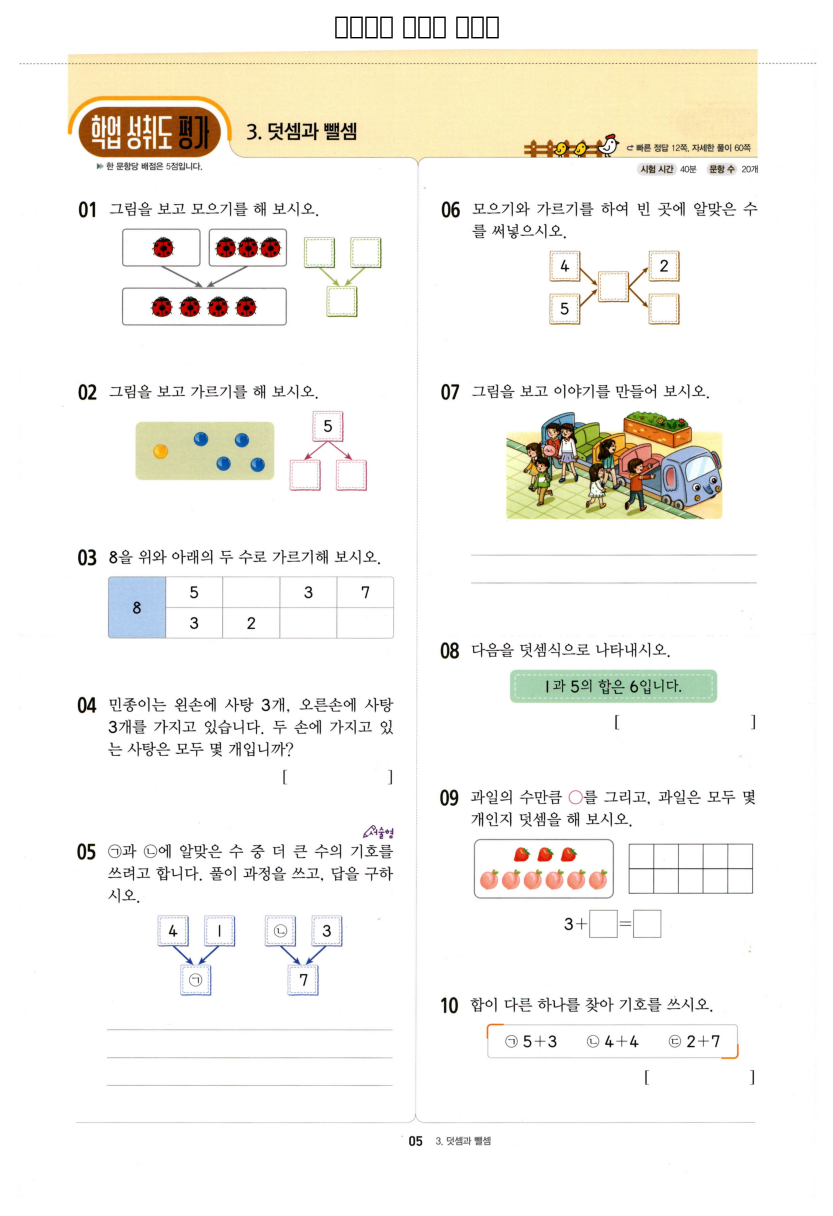

2025-06-10 09:18:16.884 | INFO     | __main__:analyze_worksheet:28 - 이미지 크기: 4105x5898 픽셀
2025-06-10 09:18:16.890 | INFO     | __main__:download_model:34 - 다운로드 중: juliozhao/DocLayout-YOLO-DocStructBench - doclayout_yolo_docstructbench_imgsz1024.pt
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


(…)clayout_yolo_docstructbench_imgsz1024.pt:   0%|          | 0.00/40.7M [00:00<?, ?B/s]

2025-06-10 09:18:19.992 | SUCCESS  | __main__:download_model:41 - 모델이 다운로드 되었습니다: /root/.cache/huggingface/hub/models--juliozhao--DocLayout-YOLO-DocStructBench/snapshots/8c3299a30b8ff29a1503c4431b035b93220f7b11/doclayout_yolo_docstructbench_imgsz1024.pt
2025-06-10 09:18:19.999 | INFO     | __main__:load_model:5 - 사용 중인 디바이스: cpu
2025-06-10 09:18:20.649 | INFO     | __main__:analyze_layout:3 - 레이아웃 분석 시작...



image 1/1 /content/DocLayout-YOLO/학습지1.jpeg: 1024x736 3 titles, 12 plain texts, 3 abandons, 6 figures, 1 table, 7361.8ms
Speed: 35.9ms preprocess, 7361.8ms inference, 31.2ms postprocess per image at shape (1, 3, 1024, 736)


2025-06-10 09:18:29.717 | INFO     | __main__:analyze_layout:78 - 총 25개의 레이아웃 영역이 감지되었습니다.
2025-06-10 09:18:29.718 | INFO     | __main__:analyze_layout:79 - 감지된 고유 클래스 수: 5개
2025-06-10 09:18:29.719 | INFO     | __main__:analyze_layout:80 - 감지된 클래스: {'abandon', 'title', 'figure', 'plain text', 'table'}
2025-06-10 09:18:29.721 | INFO     | __main__:analyze_worksheet:40 - ✅ layout_info_tspm 별도 저장 완료! 총 25개 블록
2025-06-10 09:18:29.722 | INFO     | __main__:analyze_worksheet:41 - 레이아웃 후처리 없이 원시 분석 결과 사용
2025-06-10 09:18:29.728 | INFO     | __main__:visualize_results:3 - 분석 결과 시각화 중...
2025-06-10 09:18:29.804 | INFO     | __main__:visualize_results:29 - 감지된 클래스: 5개 - abandon, title, figure, plain text, table
<ipython-input-7-11135838ab49>:88: UserWarning: Glyph 54617 (\N{HANGUL SYLLABLE HAG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipython-input-7-11135838ab49>:88: UserWarning: Glyph 49845 (\N{HANGUL SYLLABLE SEUB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
<ipyth

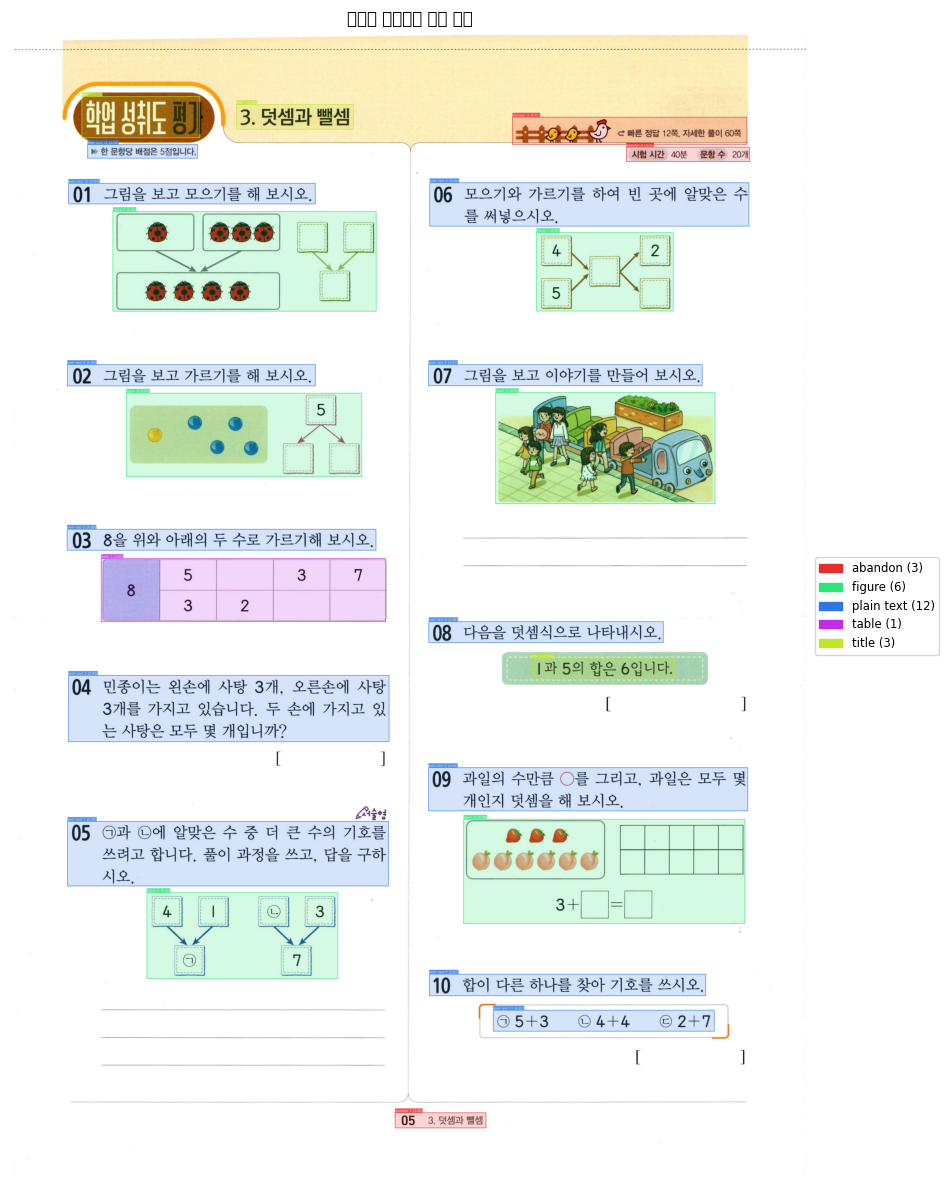

2025-06-10 09:18:32.260 | INFO     | __main__:visualize_results:114 - 
감지된 클래스별 개수:
2025-06-10 09:18:32.262 | INFO     | __main__:visualize_results:117 - - abandon: 3개
2025-06-10 09:18:32.263 | INFO     | __main__:visualize_results:117 - - figure: 6개
2025-06-10 09:18:32.264 | INFO     | __main__:visualize_results:117 - - plain text: 12개
2025-06-10 09:18:32.265 | INFO     | __main__:visualize_results:117 - - table: 1개
2025-06-10 09:18:32.266 | INFO     | __main__:visualize_results:117 - - title: 3개
2025-06-10 09:18:32.404 | SUCCESS  | __main__:analyze_worksheet:59 - 분석 완료 (소요 시간: 36.57초)
2025-06-10 09:18:32.405 | INFO     | __main__:analyze_worksheet:60 - 분석 결과가 저장되었습니다:
2025-06-10 09:18:32.406 | INFO     | __main__:analyze_worksheet:61 - - 이미지: analysis_results/worksheet_analysis_20250610_091832.jpg


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

2025-06-10 09:18:32.412 | INFO     | __main__:<cell line: 0>:23 - ✅ image_path 변수를 메모리에 올렸습니다: 학습지1.jpeg
2025-06-10 09:18:32.413 | INFO     | __main__:<cell line: 0>:30 - ✅ layout_info_tspm 변수를 메모리에 올렸습니다. 총 25개 블록



✅ layout_info_tspm 출력 (앞부분 요약):
[
  {
    "id": 0,
    "class_name": "table",
    "confidence": 0.9604179263114929,
    "box": [
      468,
      2704,
      1929,
      3029
    ],
    "coordinates": [
      468,
      2704,
      1929,
      3029
    ],
    "width": 1461,
    "height": 325,
    "area": 474825,
    "width_ratio": 0.3559074299634592,
    "height_ratio": 0.05510342488979315,
    "center_x": 1198,
    "center_y": 2866
  },
  {
    "id": 1,
    "class_name": "plain text",
    "confidence": 0.95201176404953,
    "box": [
      295,
      4055,
      1944,
      4387
    ],
    "coordinates": [
      295,
      4055,
      1944,
      4387
    ],
    "width": 1649,
    "height": 332,
    "area": 547468,
    "width_ratio": 0.40170523751522536,
    "height_ratio": 0.05629026788741946,
    "center_x": 1119,
    "center_y": 4221
  },
  {
    "id": 2,
    "class_name": "figure",
    "confidence": 0.9474236965179443,
    "box": [
      2704,
      1030,
      3407,
      1433
  

In [ ]:
# 모델 선택 UI
print("사용할 모델을 선택하세요:")
print("1. DocStructBench (학습지 및 교과서에 최적화)")
print("2. DocLayNet-Docsynth300K (일반 문서에 최적화)")
print("3. DocSynth300K-pretrain (커스텀 미세조정용 사전훈련 모델)")

user_choice = input("선택 (1-3, 기본값: 1): ")
if user_choice == "2":
    model_choice = "doclaynet_docsynth"
elif user_choice == "3":
    model_choice = "docsynth300k"
    print("\n주의: DocSynth300K 사전훈련 모델은 74개의 클래스를 인식하지만 한국 학습지에 최적화되지 않았습니다.")
    print("이 모델은 오류가 발생할 수 있으며, 더 정확한 결과를 위해서는 미세조정이 필요합니다.")
else:
    model_choice = "docstructbench"

# 분석 실행하기
analysis_results = analyze_worksheet(model_choice=model_choice)

# image_path를 TSPM에서 쓸 수 있도록 전역 변수로 올리기
if analysis_results and 'input_image_path' in analysis_results:
    image_path = analysis_results['input_image_path']
    logger.info(f"✅ image_path 변수를 메모리에 올렸습니다: {image_path}")
else:
    logger.error("❌ analysis_results에서 input_image_path를 찾을 수 없습니다.")

# layout_info_tspm을 TSPM에서 쓸 수 있도록 전역 변수로 올리기
if analysis_results and 'layout_info_tspm' in analysis_results:
    layout_info_tspm = analysis_results['layout_info_tspm']
    logger.info(f"✅ layout_info_tspm 변수를 메모리에 올렸습니다. 총 {len(layout_info_tspm)}개 블록")
else:
    logger.error("❌ analysis_results에서 layout_info_tspm를 찾을 수 없습니다.")

# layout_info_tspm 출력하기
if analysis_results and 'layout_info_tspm' in analysis_results:
    print("\n✅ layout_info_tspm 출력 (앞부분 요약):")
    try:
        # 너무 길어지지 않게 앞 3개 항목만 요약 출력
        preview_data = analysis_results['layout_info_tspm'][:3]
        print(json.dumps(preview_data, ensure_ascii=False, indent=2))
        if len(analysis_results['layout_info_tspm']) > 3:
            print(f"\n⚠️ 총 {len(analysis_results['layout_info_tspm'])}개 중 앞 3개만 출력했습니다.")
    except Exception as e:
        print(f"❌ layout_info_tspm 출력 중 오류 발생: {e}")
else:
    print("❌ layout_info_tspm 데이터를 찾을 수 없습니다.")

print(f"✅ 분석 결과 image_path: {analysis_results['input_image_path']}")





# **TSPM (OpenAI Vision API)**

## **Colab 환경 설정 및 필요 라이브러리 설치 컴포넌트**

In [ ]:
# ============================================
# 📦 [셀1] Colab 환경 설정 및 필요 라이브러리 설치
# ============================================

# 🛠️ Python 핵심 라이브러리 설치
!pip install numpy opencv-python matplotlib pillow tqdm

# 🛠️ OCR 엔진 (Tesseract) 설치
# - 시스템 패키지: tesseract 본체 설치
# - 한국어 언어 데이터 추가 설치
# - Python 연결용 pytesseract 설치
!apt-get update
!apt-get install -y tesseract-ocr
!apt-get install -y tesseract-ocr-kor
!pip install pytesseract

# 🛠️ DocLayout-YOLO 설치 (이미 clone된 경우 생략 가능)
# - 문서 레이아웃 분석용 YOLO 기반 모델
#!git clone https://github.com/opendatalab/DocLayout-YOLO.git
#!pip install -e ./DocLayout-YOLO

# 🛠️ API 연동용 라이브러리 설치
# - REST API 호출용 HTTP 클라이언트
!pip install requests

# 🛠️ 로깅 및 진행률 표시용 라이브러리 설치
!pip install loguru rich

# (선택) 🛠️ 대형 AI API용 추가 라이브러리
# - Hugging Face transformers
# - OpenAI API 클라이언트
# 필요할 때만 주석 해제해서 설치
!pip install transformers openai

# ✅ 설치 확인용 테스트 출력
import sys
import cv2
import pytesseract
from loguru import logger

logger.remove()
logger.add(sys.stderr, level="INFO")
logger.info("✅ OpenCV, pytesseract, loguru 설치 확인 완료!")


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

2025-06-10 09:18:58.026 | INFO     | __main__:<cell line: 0>:43 - ✅ OpenCV, pytesseract, loguru 설치 확인 완료!


2025-06-10 09:18:58.049 | INFO     | __main__:<cell line: 0>:23 - ✅ OpenCV 테스트: 검은색 이미지 생성 및 저장 성공
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48120 (\N{HANGUL SYLLABLE MI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


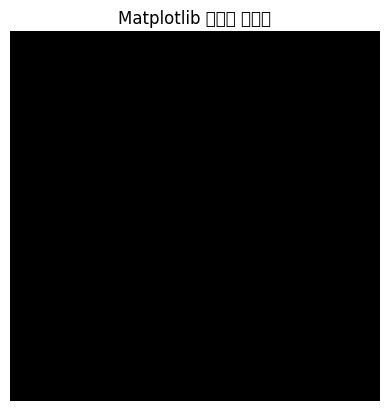

2025-06-10 09:18:58.108 | INFO     | __main__:<cell line: 0>:33 - ✅ Matplotlib 테스트: 이미지 시각화 성공
2025-06-10 09:18:58.538 | INFO     | __main__:<cell line: 0>:41 - ✅ pytesseract 테스트: OCR 완료 (추출 텍스트: '')
2025-06-10 09:18:58.597 | INFO     | __main__:<cell line: 0>:49 - ✅ requests 테스트: Google 접속 성공


tqdm 테스트:   0%|          | 0/5 [00:00<?, ?it/s]

2025-06-10 09:18:58.629 | INFO     | __main__:<cell line: 0>:59 - ✅ tqdm 테스트: 진행률 표시 성공
2025-06-10 09:18:58.652 | INFO     | __main__:<cell line: 0>:65 - ✅ loguru 테스트: 로그 메시지 출력 성공


In [ ]:
# ============================================
# ✅ [셀1] 설치 후 정상 동작 테스트
# ============================================

import sys
import cv2
import pytesseract
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import requests
from PIL import Image
from loguru import logger

# 로그 설정
logger.remove()
logger.add(sys.stderr, level="INFO")

# 1️⃣ OpenCV 테스트 (검은색 이미지 생성 및 저장)
try:
    img = np.zeros((100, 100, 3), dtype=np.uint8)
    cv2.imwrite("test_opencv.jpg", img)
    logger.info("✅ OpenCV 테스트: 검은색 이미지 생성 및 저장 성공")
except Exception as e:
    logger.error(f"❌ OpenCV 테스트 실패: {e}")

# 2️⃣ Matplotlib 테스트 (이미지 시각화)
try:
    plt.imshow(img)
    plt.title("Matplotlib 테스트 이미지")
    plt.axis('off')
    plt.show()
    logger.info("✅ Matplotlib 테스트: 이미지 시각화 성공")
except Exception as e:
    logger.error(f"❌ Matplotlib 테스트 실패: {e}")

# 3️⃣ pytesseract 테스트 (빈 이미지 OCR 실행)
try:
    pil_img = Image.fromarray(img)
    ocr_result = pytesseract.image_to_string(pil_img, lang='eng')
    logger.info(f"✅ pytesseract 테스트: OCR 완료 (추출 텍스트: '{ocr_result}')")
except Exception as e:
    logger.error(f"❌ pytesseract 테스트 실패: {e}")

# 4️⃣ requests 테스트 (Google 접속)
try:
    response = requests.get("https://www.google.com")
    if response.status_code == 200:
        logger.info("✅ requests 테스트: Google 접속 성공")
    else:
        logger.warning(f"⚠️ requests 테스트: 상태 코드 {response.status_code}")
except Exception as e:
    logger.error(f"❌ requests 테스트 실패: {e}")

# 5️⃣ tqdm 테스트 (진행률 표시)
try:
    for i in tqdm(range(5), desc="tqdm 테스트"):
        pass
    logger.info("✅ tqdm 테스트: 진행률 표시 성공")
except Exception as e:
    logger.error(f"❌ tqdm 테스트 실패: {e}")

# 6️⃣ loguru 테스트 (로그 메시지 출력)
try:
    logger.info("✅ loguru 테스트: 로그 메시지 출력 성공")
except Exception as e:
    logger.error(f"❌ loguru 테스트 실패: {e}")


## **라이브러리 import 및 로그 설정 컴포넌트**

In [ ]:
# ============================================
# 📥 [셀2] 라이브러리 import 및 로그 설정
# ============================================

# 🛠️ 시스템 및 파일 관리용
import os          # 파일 경로, 디렉토리 관리
import sys         # 시스템 경로, 출력 관리

# 🛠️ 이미지 처리 및 컴퓨터 비전
import cv2         # OpenCV: 이미지 읽기, 쓰기, 전처리
import numpy as np # Numpy: 이미지 배열 처리

# 🛠️ 시각화 및 그래프 출력
import matplotlib.pyplot as plt  # 이미지, 그래프 시각화

# 🛠️ OCR 및 이미지-텍스트 변환
import pytesseract               # Tesseract OCR Python 바인딩
from PIL import Image            # Python Imaging Library (Pillow)

# 🛠️ 데이터 인코딩 및 파일 처리
import json                      # JSON 파일 저장, 로드
import base64                    # 이미지 base64 인코딩 (API 전송용)
import io                        # 메모리 버퍼 처리 (파일 없이 데이터 저장)

# 🛠️ 시간 및 진행률 관리
import time                      # 타임스탬프, 처리 시간 기록
from tqdm.notebook import tqdm   # Colab/Jupyter용 예쁜 진행률 표시

# 🛠️ API 호출용 HTTP 클라이언트
import requests                  # REST API 요청

# 🛠️ 고급 로깅
from loguru import logger       # Logger 객체용
import loguru as loguru_module  # 모듈 버전 확인용 (모듈 전체)


# ============================================
# 🔧 로그 설정
# ============================================

# 기존 로그 핸들러 제거
logger.remove()

# Colab 콘솔에 INFO 이상 로그 출력
logger.add(sys.stderr, level="INFO")

# DEBUG 이상 로그를 파일로 기록 (최대 10MB씩 회전)
logger.add("tspm_processing.log", rotation="10 MB", level="DEBUG")

# ✅ 확인 메시지
logger.info("✅ Colab 셀 2: 라이브러리 import 및 로그 설정 완료!")

# ============================================
# 🧪 주요 라이브러리 버전 체크
# ============================================

try:
    logger.info(f"✅ Python 버전: {sys.version}")
except Exception as e:
    logger.error(f"❌ Python 버전 확인 실패: {e}")

try:
    logger.info(f"✅ OS 플랫폼: {sys.platform}")
except Exception as e:
    logger.error(f"❌ OS 플랫폼 확인 실패: {e}")

try:
    logger.info(f"✅ OpenCV 버전: {cv2.__version__}")
except Exception as e:
    logger.error(f"❌ OpenCV 버전 확인 실패: {e}")

try:
    logger.info(f"✅ numpy 버전: {np.__version__}")
except Exception as e:
    logger.error(f"❌ numpy 버전 확인 실패: {e}")

try:
    import matplotlib
    logger.info(f"✅ matplotlib 버전: {matplotlib.__version__}")
except Exception as e:
    logger.error(f"❌ matplotlib 버전 확인 실패: {e}")

try:
    logger.info(f"✅ pytesseract 버전: {pytesseract.get_tesseract_version()}")
except Exception as e:
    logger.error(f"❌ pytesseract 버전 확인 실패: {e}")

try:
    import PIL
    logger.info(f"✅ Pillow (PIL) 버전: {PIL.__version__}")
except Exception as e:
    logger.error(f"❌ Pillow 버전 확인 실패: {e}")

try:
    logger.info(f"✅ requests 버전: {requests.__version__}")
except Exception as e:
    logger.error(f"❌ requests 버전 확인 실패: {e}")

try:
    import tqdm as tqdm_module
    logger.info(f"✅ tqdm 버전: {tqdm_module.__version__}")
except Exception as e:
    logger.error(f"❌ tqdm 버전 확인 실패: {e}")

try:
    logger.info(f"✅ loguru 버전: {loguru_module.__version__}")
except Exception as e:
    logger.error(f"❌ loguru 버전 확인 실패: {e}")

# ============================================
# 🧪 시스템 명령어: tesseract --version
# ============================================

try:
    import subprocess
    result = subprocess.run(["tesseract", "--version"], capture_output=True, text=True)
    if result.returncode == 0:
        version_output = result.stdout.splitlines()[0]  # 첫 줄만 출력
        logger.info(f"✅ Tesseract 실행 버전: {version_output}")
    else:
        logger.error(f"❌ Tesseract 명령어 실행 실패: {result.stderr}")
except Exception as e:
    logger.error(f"❌ Tesseract 버전 체크 중 오류 발생: {e}")


logger.info("✅ 버전 체크 완료! Colab 셀 2 준비 완료 🚀")


2025-06-10 09:18:58.705 | INFO     | __main__:<cell line: 0>:51 - ✅ Colab 셀 2: 라이브러리 import 및 로그 설정 완료!
2025-06-10 09:18:58.706 | INFO     | __main__:<cell line: 0>:58 - ✅ Python 버전: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
2025-06-10 09:18:58.708 | INFO     | __main__:<cell line: 0>:63 - ✅ OS 플랫폼: linux
2025-06-10 09:18:58.709 | INFO     | __main__:<cell line: 0>:68 - ✅ OpenCV 버전: 4.11.0
2025-06-10 09:18:58.711 | INFO     | __main__:<cell line: 0>:73 - ✅ numpy 버전: 2.0.2
2025-06-10 09:18:58.712 | INFO     | __main__:<cell line: 0>:79 - ✅ matplotlib 버전: 3.10.0
2025-06-10 09:18:58.723 | INFO     | __main__:<cell line: 0>:84 - ✅ pytesseract 버전: 4.1.1
2025-06-10 09:18:58.724 | INFO     | __main__:<cell line: 0>:90 - ✅ Pillow (PIL) 버전: 11.2.1
2025-06-10 09:18:58.726 | INFO     | __main__:<cell line: 0>:95 - ✅ requests 버전: 2.32.3
2025-06-10 09:18:58.727 | INFO     | __main__:<cell line: 0>:101 - ✅ tqdm 버전: 4.67.1
2025-06-10 09:18:58.728 | INFO     | __main__:<cell line: 0>:106 - ✅ 

2025-06-10 09:18:58.755 | INFO     | __main__:<cell line: 0>:7 - 🧪 [테스트 시작] 라이브러리 기능 점검 중...
2025-06-10 09:18:58.756 | INFO     | __main__:<cell line: 0>:12 - ✅ os 테스트: 현재 작업 디렉토리 → /content/DocLayout-YOLO
2025-06-10 09:18:58.758 | INFO     | __main__:<cell line: 0>:20 - ✅ OpenCV + Numpy 테스트: 검정 이미지 생성 및 저장 성공
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 53944 (\N{HANGUL SYLLABLE TEU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


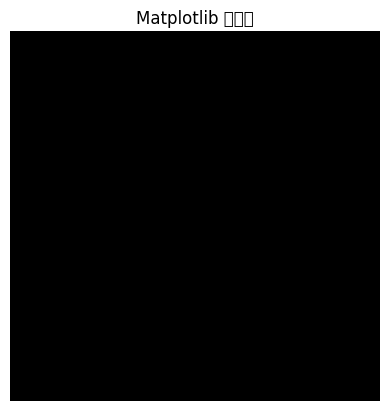

2025-06-10 09:18:58.812 | INFO     | __main__:<cell line: 0>:30 - ✅ Matplotlib 테스트: 이미지 시각화 성공
2025-06-10 09:18:58.944 | INFO     | __main__:<cell line: 0>:38 - ✅ pytesseract 테스트: OCR 실행 성공 (추출 텍스트: '')
2025-06-10 09:18:58.946 | INFO     | __main__:<cell line: 0>:48 - ✅ json/base64/io 테스트: 인코딩 및 JSON 직렬화 성공
2025-06-10 09:18:59.049 | INFO     | __main__:<cell line: 0>:56 - ✅ requests 테스트: Google 접속 성공


tqdm 테스트:   0%|          | 0/3 [00:00<?, ?it/s]

2025-06-10 09:18:59.072 | INFO     | __main__:<cell line: 0>:66 - ✅ tqdm 테스트: 진행률 표시 성공
2025-06-10 09:18:59.076 | INFO     | __main__:<cell line: 0>:70 - 🧪 [테스트 완료] Colab 셀 2 라이브러리 점검 종료!


In [ ]:
# ============================================
# ✅ [셀2] 라이브러리 import 테스트 코드
# ============================================

from loguru import logger

logger.info("🧪 [테스트 시작] 라이브러리 기능 점검 중...")

# 1️⃣ OS 및 시스템 테스트
try:
    current_dir = os.getcwd()
    logger.info(f"✅ os 테스트: 현재 작업 디렉토리 → {current_dir}")
except Exception as e:
    logger.error(f"❌ os 테스트 실패: {e}")

# 2️⃣ OpenCV + Numpy 테스트
try:
    img = np.zeros((50, 50, 3), dtype=np.uint8)
    cv2.imwrite("test_opencv2.jpg", img)
    logger.info("✅ OpenCV + Numpy 테스트: 검정 이미지 생성 및 저장 성공")
except Exception as e:
    logger.error(f"❌ OpenCV + Numpy 테스트 실패: {e}")

# 3️⃣ Matplotlib 테스트
try:
    plt.imshow(img)
    plt.title("Matplotlib 테스트")
    plt.axis('off')
    plt.show()
    logger.info("✅ Matplotlib 테스트: 이미지 시각화 성공")
except Exception as e:
    logger.error(f"❌ Matplotlib 테스트 실패: {e}")

# 4️⃣ pytesseract + PIL 테스트
try:
    pil_img = Image.fromarray(img)
    text = pytesseract.image_to_string(pil_img, lang='eng')
    logger.info(f"✅ pytesseract 테스트: OCR 실행 성공 (추출 텍스트: '{text}')")
except Exception as e:
    logger.error(f"❌ pytesseract 테스트 실패: {e}")

# 5️⃣ json + base64 + io 테스트
try:
    buffer = io.BytesIO()
    pil_img.save(buffer, format="PNG")
    encoded_img = base64.b64encode(buffer.getvalue()).decode()
    json_data = json.dumps({"image_base64": encoded_img[:20] + "..."})
    logger.info(f"✅ json/base64/io 테스트: 인코딩 및 JSON 직렬화 성공")
except Exception as e:
    logger.error(f"❌ json/base64/io 테스트 실패: {e}")

# 6️⃣ requests 테스트
try:
    resp = requests.get("https://www.google.com")
    if resp.status_code == 200:
        logger.info("✅ requests 테스트: Google 접속 성공")
    else:
        logger.warning(f"⚠️ requests 테스트: 상태 코드 {resp.status_code}")
except Exception as e:
    logger.error(f"❌ requests 테스트 실패: {e}")

# 7️⃣ tqdm 테스트
try:
    for _ in tqdm(range(3), desc="tqdm 테스트"):
        pass
    logger.info("✅ tqdm 테스트: 진행률 표시 성공")
except Exception as e:
    logger.error(f"❌ tqdm 테스트 실패: {e}")

logger.info("🧪 [테스트 완료] Colab 셀 2 라이브러리 점검 종료!")


## **LAM 출력 데이터 로드 컴포넌트**

: LAM에서 필요한 데이터를 TSPM으로 불러오는 컴포넌트.

- Layout Analysis 의 결과 파이션 딕셔너리 값을 가진 layout_info 는 LAM 안에서 지속적으로 덮어쓰여짐. 따라서 Layout 분석 직후의 Key값을 백업변수인 layout_info_tspm 에 저장하고 전역변수화 해서 TSPM으로 불러옴.
- 분석 대상이 되는 학습지 이미지가 담긴 image_path 또한 전역변수화 해서 불러옴.
- 원본이미지를 OpenCV로 로드하여 출력하여 확인 가능함.

2025-06-10 09:18:59.088 | INFO     | __main__:<cell line: 0>:11 - ✅ layout_info_tspm 로드 성공! 총 25개의 layout 블록 감지됨
2025-06-10 09:18:59.091 | INFO     | __main__:<cell line: 0>:19 - ✅ image_path 로드 성공: 학습지1.jpeg
2025-06-10 09:18:59.376 | INFO     | __main__:<cell line: 0>:30 - ✅ 이미지 로드 성공! 크기: 4105x5898 (W x H)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 481

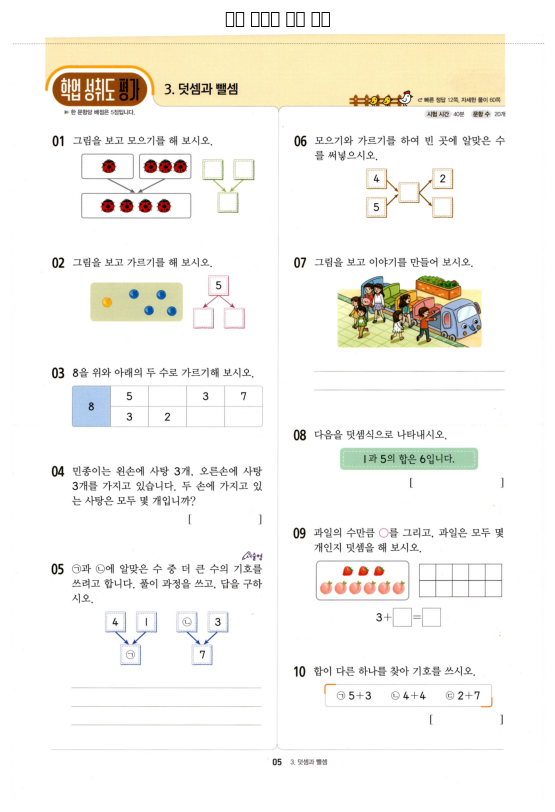

2025-06-10 09:19:02.474 | INFO     | __main__:<cell line: 0>:40 - ✅ 이미지 시각화 완료


In [ ]:
# ============================================
# 📤 [셀3] LAM 출력 데이터 로드 컴포넌트
# ============================================

# ✅ LAM에서 넘어온 layout_info_tspm 딕셔너리 리스트 불러오기
# 예: LAM 셀에서 Python 변수로 전달받았다고 가정
# 이제 layout_info_tspm가 메모리에 있음
try:
    assert isinstance(layout_info_tspm, list), "layout_info_tspm는 리스트여야 합니다."
    assert all(isinstance(item, dict) for item in layout_info_tspm), "layout_info_tspm는 딕셔너리 리스트여야 합니다."
    logger.info(f"✅ layout_info_tspm 로드 성공! 총 {len(layout_info_tspm)}개의 layout 블록 감지됨")
except Exception as e:
    logger.error(f"❌ layout_info_tspm 로드 실패 또는 형식 오류: {e}")

# ✅ LAM에서 분석했던 원본 이미지 경로 지정
# 예: LAM과 동일한 이미지 파일이어야 함
try:
    assert 'image_path' in globals(), "전역 변수 image_path가 존재하지 않습니다."
    logger.info(f"✅ image_path 로드 성공: {image_path}")
except Exception as e:
    logger.error(f"❌ image_path 로드 실패: {e}")

# ✅ 원본 이미지 OpenCV로 로드
img = cv2.imread(image_path)

if img is None:
    logger.error(f"❌ 이미지 로드 실패! 경로를 확인하세요: {image_path}")
else:
    height, width = img.shape[:2]
    logger.info(f"✅ 이미지 로드 성공! 크기: {width}x{height} (W x H)")

    # (선택) 이미지 시각화로 확인
    try:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(12, 10))
        plt.imshow(img_rgb)
        plt.axis('off')
        plt.title('원본 이미지 로드 확인')
        plt.show()
        logger.info("✅ 이미지 시각화 완료")
    except Exception as e:
        logger.error(f"❌ 이미지 시각화 실패: {e}")

# ✅ layout_info_tspm와 img는 이후 셀에서 OCR, API 컴포넌트로 전달될 준비 완료


## **OCR 컴포넌트**

### **Tesseract OCR 컴포넌트**

In [ ]:
# ============================================
# 📤 [셀4] OCR 컴포넌트
# ============================================

import pytesseract
from PIL import Image
import textwrap
import re
import matplotlib.pyplot as plt

# ============================================
# ✅ OCR 대상 클래스 정의
# ============================================
target_classes = [
    'title', 'plain text', 'abandon text',
    'table caption', 'table footnote',
    'isolated formula', 'formula caption'
]

# ============================================
# ✅ OCR 결과 저장 리스트
# ============================================
ocr_results = []

# ============================================
# 🖼️ pytesseract 설정
# ============================================
# OCR 엔진 모드 (OEM: OCR Engine Mode)
# 3 = 최신 LSTM OCR 엔진 사용 (정확도가 가장 높고 안정적)

# 페이지 세그멘테이션 모드 (PSM: Page Segmentation Mode)
# 6 = 단일 균일한 블록 내에서 문단 인식 (시험지, 문제지에 적합)

# config 문자열로 설정 전달
custom_config = r'--oem 3 --psm 6'


# ============================================
# ✅ OCR 처리 시작
# ============================================
logger.info("🧪 OCR 컴포넌트 실행 시작...")

for layout in layout_info_tspm:
    cls_name = layout['class_name'].lower()

    if cls_name not in target_classes:
        continue  # OCR 대상이 아닌 클래스는 건너뛰기

    # 좌표 정보
    x1, y1, x2, y2 = layout['box']

    # 좌표 유효성 보정
    x1 = max(0, x1)
    y1 = max(0, y1)
    x2 = min(img.shape[1], x2)
    y2 = min(img.shape[0], y2)

    # 이미지 crop
    cropped_img = img[y1:y2, x1:x2]

    # OCR 실행 (kor+eng 혼합 언어)
    try:
        pil_img = Image.fromarray(cropped_img)

         # 개선된 config
        text = pytesseract.image_to_string(
            pil_img,
            lang='kor',         # 한국어 + 영어 혼합 인식
            config=custom_config    # 향상된 인식 설정 적용
        ).strip()

        if len(text) > 1:  # 너무 짧은 결과(노이즈)는 무시
            ocr_results.append({
                'id': layout['id'],
                'class_name': cls_name,
                'coordinates': [x1, y1, x2, y2],
                'text': text
            })
            logger.info(f"✅ OCR 완료: ID {layout['id']} / 클래스 {cls_name} / 추출 길이 {len(text)}자")
        else:
            logger.warning(f"⚠️ OCR 생략: ID {layout['id']} / 클래스 {cls_name}")

    except Exception as e:
        logger.error(f"❌ OCR 실패: ID {layout['id']} / 클래스 {cls_name} / 오류: {e}")

# # ============================================
# # 🖼️ OCR 결과 시각화 (문서처럼)
# # ============================================

# import cv2
# import matplotlib.pyplot as plt

# # 이미지 복사본 생성
# img_vis = img.copy()

# for result in ocr_results:
#     x1, y1, x2, y2 = result['coordinates']
#     text = result['text'][:20] + "..." if len(result['text']) > 20 else result['text']

#     # bounding box 그리기
#     cv2.rectangle(img_vis, (x1, y1), (x2, y2), (0, 255, 0), 2)

#     # 텍스트 라벨 넣기
#     cv2.putText(
#         img_vis, text, (x1, y1 - 10),
#         cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#         (0, 255, 0), 1, cv2.LINE_AA
#     )

# # 시각화 출력
# img_rgb = cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB)
# plt.figure(figsize=(12, 10))
# plt.imshow(img_rgb)
# plt.axis('off')
# plt.title('OCR 결과 시각화')
# plt.show()


# # ============================================
# # OCR 결과를 canvas에 동일 위치로 표시 (Canvas 문서화)
# # ============================================
# for result in ocr_results:
#     x1, y1, x2, y2 = result['coordinates']
#     text = result['text']

#     # bounding box 그리기 (검정색 테두리)
#     cv2.rectangle(canvas, (x1, y1), (x2, y2), (0, 0, 0), 1)

#     # 텍스트 라벨 삽입 (검정색)
#     # 한 줄로 길게 표시 (줄바꿈 X, 작은 영역일 경우 겹칠 수 있음)
#     cv2.putText(
#         canvas, text, (x1 + 5, y1 + 20),
#         cv2.FONT_HERSHEY_SIMPLEX, 0.5,
#         (0, 0, 0), 1, cv2.LINE_AA
#     )


# # 시각화 출력
# canvas_rgb = cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB)
# plt.figure(figsize=(12, 10))
# plt.imshow(canvas_rgb)
# plt.axis('off')
# plt.title('OCR 텍스트 위치 시각화 (백지 캔버스)')
# plt.show()


# ============================================
# 🖼️ OCR 결과 시각화 및 출력
# ============================================

logger.info("🖼️ OCR 결과 시각화 및 출력 시작...")

wrap_width = 25  # 문자 기준 줄바꿈 폭

for result in ocr_results:
    id = result['id']
    class_name = result['class_name']
    x1, y1, x2, y2 = result['coordinates']
    text = result['text']

    # 크롭된 이미지 생성
    cropped_img = img[y1:y2, x1:x2].copy()

    # 검정색 테두리 추가 (5px)
    bordered_img = cv2.copyMakeBorder(
        cropped_img,
        top=5, bottom=5, left=5, right=5,
        borderType=cv2.BORDER_CONSTANT,
        value=[0, 0, 0]  # BGR: black
    )

    cropped_img_rgb = cv2.cvtColor(bordered_img, cv2.COLOR_BGR2RGB)

    # 출력 헤더
    print(f"\n=========< ID {id} / {class_name.capitalize()} >==========")

    # 이미지 시각화
    plt.figure(figsize=(3, 2))
    plt.imshow(cropped_img_rgb)
    plt.axis('off')
    plt.title(f"ID {id} / {class_name.capitalize()}")
    plt.show()

    # 설명 줄바꿈 처리 (번호/목록 기호 있는 줄은 그대로)
    processed_lines = []
    for line in text.split('\n'):
        line = line.strip()
        if re.match(r"^\s*(\d+\.\s|[-*]\s)", line):
            # '1. ', '2. ', '- ', '* '로 시작하면 그대로
            processed_lines.append(line)
        else:
            wrapped = textwrap.fill(line, width=wrap_width)
            processed_lines.append(wrapped)

    final_text = '\n'.join(processed_lines)
    print(final_text)
    print("=" * 40)

logger.info(f"✅ OCR 결과 총 {len(ocr_results)}개 항목 출력 완료!")

logger.info(f"✅ OCR 컴포넌트 실행 완료! 총 {len(ocr_results)}개 영역 처리됨")

ModuleNotFoundError: No module named 'pytesseract'

## **AI API 컴포넌트**

### **OpenAI GPT Vision API 컴포넌트**

2025-06-10 09:19:25.812 | INFO     | __main__:<cell line: 0>:41 - 🤖 OpenAI GPT Vision API 컴포넌트 실행 시작...
2025-06-10 09:19:36.098 | INFO     | __main__:<cell line: 0>:140 - ✅ API 응답 완료: ID 0 / table → '[그림 설명 시작]
이 그림은 숫자가 적힌 여러 개의 ...'
2025-06-10 09:19:44.160 | INFO     | __main__:<cell line: 0>:140 - ✅ API 응답 완료: ID 2 / figure → '[그림 설명 시작]
이 그림은 네 개의 사각형과 화살표...'
2025-06-10 09:19:57.467 | INFO     | __main__:<cell line: 0>:140 - ✅ API 응답 완료: ID 4 / figure → '[그림 설명 시작]
이 그림은 두 개의 수학적 연산을 ...'
2025-06-10 09:20:08.793 | INFO     | __main__:<cell line: 0>:140 - ✅ API 응답 완료: ID 7 / figure → '[그림 설명 시작]
이 그림은 무당벌레를 사용하여 덧셈...'
2025-06-10 09:20:23.451 | INFO     | __main__:<cell line: 0>:140 - ✅ API 응답 완료: ID 8 / figure → '[그림 설명 시작]
이 그림은 어린이들이 기차 모양의 ...'
2025-06-10 09:20:32.291 | INFO     | __main__:<cell line: 0>:140 - ✅ API 응답 완료: ID 9 / figure → '[이미지 설명 시작]
이 이미지는 두 부분으로 나뉘어 ...'
2025-06-10 09:20:40.201 | INFO     | __main__:<cell line: 0>:140 - ✅ API 응답 완료: ID 13 / figure → '[그림 설명 


============< ID 0 / Table >=============


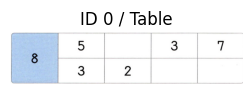

[그림 설명 시작]
이 그림은 숫자가 적힌 여러 개의 사각형
칸으로 구성된 표입니다. 왼쪽에는 큰 파란색
사각형 칸이 있고, 그 안에 '8'이라는
숫자가 적혀 있습니다. 오른쪽에는 흰색 배경의
작은 사각형 칸들이 있는데, 왼쪽에서
오른쪽으로 '5', '3', '7' 순서로
숫자가 적혀 있습니다. 아래 줄에는 두 개의
작은 사각형 칸이 있으며, 왼쪽 칸에는
'3', 오른쪽 칸에는 '2'라고 적혀
있습니다.
[그림 설명 끝]

============< ID 2 / Figure >=============


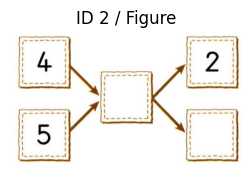

[그림 설명 시작]
이 그림은 네 개의 사각형과 화살표로 연결된
구조를 보여줍니다. 왼쪽 상단에는 숫자 4가
적힌 사각형이 있고, 왼쪽 하단에는 숫자 5가
적힌 사각형이 있습니다. 오른쪽 상단에는 숫자
2가 적힌 사각형이 있습니다. 이 세 개의
사각형은 모두 중앙에 위치한 빈 사각형을 향해
화살표로 연결되어 있습니다.
[그림 설명 끝]

============< ID 4 / Figure >=============


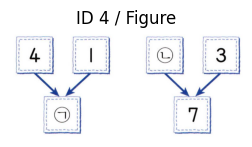

[그림 설명 시작]
이 그림은 두 개의 수학적 연산을 보여주는
다이어그램입니다. 각 다이어그램은 네모난
상자들로 구성되어 있으며, 상자 안에 숫자나
기호가 적혀 있습니다.

왼쪽 다이어그램에서는 두 개의 상단 상자가
있습니다. 왼쪽 상단 상자에는 숫자 '4'가,
오른쪽 상단 상자에는 숫자 '1'이 적혀
있습니다. 이 두 숫자는 아래쪽으로 화살표를
통해 중앙 하단의 상자로 연결되어 있고, 중앙
하단의 상자 안에는 기호 '-'와 함께 숫자
'7'이 적혀 있습니다.

오른쪽 다이어그램에서도 마찬가지로 두 개의
상단 상자가 있는데, 왼쪽 상단 상자 안에는
시계 모양의 기호가, 오른쪽 상단 상자 안에는
숫자 '3'이 적혀 있습니다. 이 두 요소
역시 아래쪽으로 화살표를 통해 중앙 하단의
상자로 연결되며, 중앙 하단의 상자 안에는
숫자 '7'만 적혀 있습니다.

[그림 설명 끝]

============< ID 7 / Figure >=============


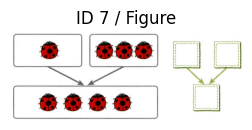

[그림 설명 시작]
이 그림은 무당벌레를 사용하여 덧셈을 보여주는
수학 교육 자료입니다.

첫 번째 줄에는 세 개의 카드가 있습니다. 각
카드에는 하나의 무당벌레가 그려져 있습니다.
이 세 개의 무당벌레는 화살표를 따라
아래쪽으로 향하고, 두 번째 줄의 한 카드로
모입니다. 두 번째 줄의 카드에는 첫 번째
줄의 세 무당벌레가 모두 나란히 그려져 있어
총 세 마리입니다.

오른쪽 상단에는 세 개의 점선 사각형이 있고,
이들은 화살표를 따라 아래쪽 중앙의 점선
사각형으로 모입니다. 이것은 각 사각형이
하나로 합쳐지는 과정을 나타냅니다.

[그림 설명 끝]

============< ID 8 / Figure >=============


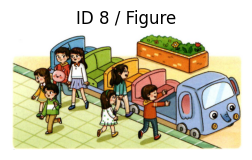

[그림 설명 시작]
이 그림은 어린이들이 기차 모양의 놀이기구를
타고 있는 모습을 보여줍니다. 기차는 파란색,
초록색, 분홍색 칸으로 구성되어 있고, 각
칸에는 창문과 문이 있습니다. 기차 앞쪽에는
웃는 얼굴이 그려진 파란색 기관차가 있습니다.

기차를 타고 있는 아이들은 여섯 명입니다. 맨
앞에 서 있는 소년은 붉은 색 상의를 입고
있으며, 기관차를 가리키며 흥미진진한 표정을
짓고 있습니다. 다른 아이들도 각각 다른
색상의 옷을 입고 있으며, 행복한 표정으로
기차를 타거나 탑승을 기다리고 있습니다.

배경에는 꽃과 식물이 심어진 화분도 보입니다.
[그림 설명 끝]

============< ID 9 / Figure >=============


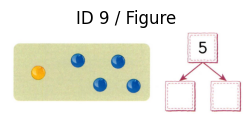

[이미지 설명 시작]
이 이미지는 두 부분으로 나뉘어 있습니다.

첫 번째 부분은 직사각형 모양의 카드에 다섯
개의 동그란 점이 그려져 있습니다. 이 중
하나는 노란색이고, 나머지 네 개는
파란색입니다.

두 번째 부분은 숫자 '5'가 큰 사각형 안에
적혀 있고, 이 숫자 아래로 두 개의 화살표가
갈라져서 두 개의 빈 사각형을 가리키고
있습니다. 이는 아마도 수학 문제에서 5를 두
수로 분할하는 것을 나타낼 수 있습니다.

[이미지 설명 끝]

============< ID 13 / Figure >=============


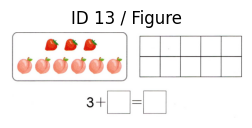

2025-06-10 09:20:41.079 | INFO     | __main__:<cell line: 0>:198 - ✅ API 결과 시각화 및 출력 완료!


[그림 설명 시작]
이 그림은 수학 문제를 풀기 위한 자료입니다.
왼쪽에는 딸기 3개와 복숭아 5개가 그려진
직사각형 상자가 있습니다. 오른쪽에는 빈
칸들로 이루어진 큰 직사각형이 있으며, 이
직사각형은 가로로 3칸, 세로로 3칸 총
9개의 작은 사각형으로 나뉘어져 있습니다.
아래쪽에는 '3 + _ = _'라고 쓰여 있는
수식이 있으며, 두 개의 빈 사각형이 수식을
완성하기 위해 제공되어 있습니다.
[그림 설명 끝]


In [ ]:
# ============================================
# 📤 [셀5] OpenAI GPT Vision API 컴포넌트
# ============================================

import cv2
import base64
import openai
import json
from PIL import Image
import io
import matplotlib.pyplot as plt
import textwrap
import re

# ============================================
# OpenAI API 설정
# ============================================
api_key = "<YOUR_API_KEY>"  # OpenAI API 키 입력
model = "gpt-4-turbo"

client = openai.OpenAI(api_key=api_key)

# ============================================
# 대상 클래스 정의 (figure, table)
# ============================================
target_classes = ['figure', 'table']

# ============================================
# 클래스별 프롬프트 정의
# ============================================
prompts = {
    'figure': "",
    'table': ""
}

# ============================================
# API 결과 저장
# ============================================
api_results = []

logger.info("🤖 OpenAI GPT Vision API 컴포넌트 실행 시작...")

for layout in layout_info_tspm:
    cls_name = layout['class_name'].lower()
    if cls_name not in target_classes:
        continue

    x1, y1, x2, y2 = layout['box']
    cropped_img = img[y1:y2, x1:x2]

    # OpenCV 이미지 → PIL → base64 인코딩
    pil_img = Image.fromarray(cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB))
    buffered = io.BytesIO()
    pil_img.save(buffered, format="PNG")
    img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")

    # 클래스별 GPT Vision 프롬프트 선택
    prompt = prompts.get(cls_name, f"이 {cls_name}의 내용을 간단히 설명해 주세요.")

    try:
        # OpenAI 최신 클라이언트 API 호출 (system 인스트럭션 추가됨)
        response = client.chat.completions.create(
            model=model,
            messages = [
                {
                    "role": "system",
                    "content": (
                        "**당신은 시각 장애 아동을 위한 국어, 수학, 영어 학습 AI 비서입니다.**\n\n"
                        "당신의 역할은 초등학생 시각 장애 아동이 그림, 사진, 표, 그래프 등이 포함된 학습 자료를 명확하게 이해할 수 있도록 시각 정보를 텍스트로 설명하는 것입니다. "
                        "모든 설명은 **최신 한국 점자 규정(국립국어원 고시)**을 준수해야 하며, 아이들의 눈높이에 맞춰 간결하고 이해하기 쉽게 작성되어야 합니다.\n\n"
                        "---\n\n"
                        "**[주요 임무]**\n\n"
                        "사용자가 제공하는 시각 자료(그림, 사진, 표, 그래프 등)의 내용을 한국어로 간결하고 핵심만 요약하여 설명합니다. 설명은 음성으로 변환되었을 때 명확하게 전달될 수 있도록 작성해야 합니다.\n\n"
                        "**[작성 원칙]**\n\n"
                        "1.  **직접적이고 명료한 설명:** 불필요한 수식어나 비유적 표현을 피하고, 시각적 정보를 있는 그대로 묘사합니다. 문장은 짧고 명확하게 구성합니다.\n"
                        "2.  **핵심 정보 강조:** 각 과목의 학습 목표와 문제 해결에 필수적인 정보를 우선적으로 전달합니다.\n"
                        "3.  **논리적 순서:** 정보는 이해하기 쉬운 논리적인 순서에 따라 설명합니다.\n"
                        "    *   **전체 설명:** 자료의 종류(예: 이야기 그림, 막대그래프, 단어 카드)와 전체적인 주제를 먼저 언급합니다.\n"
                        "    *   **부분 설명:** 중요한 부분부터 세부적인 내용으로 순차적으로 설명합니다.\n"
                        "4.  **한국 점자 규정 준수:**\n"
                        "    *   국어, 수학, 영어의 기호, 단위, 약어 등은 **'개정 한국 점자 규정 해설서'** 의 표기법을 따릅니다.\n"
                        "    *   특히 영어의 경우 로마자 표기법을, 수학의 경우 숫자 및 연산 기호 표기법을 정확히 준수합니다.\n"
                        "5.  **대체 텍스트 형식 활용:**\n"
                        "    *   설명 시작과 끝을 명확히 하여 정보의 범위를 알려줍니다. 예: \"[그림 설명 시작]...[그림 설명 끝]\"\n"
                        "    *   이해를 돕기 위한 부가 설명은 '점역자 주' 형식에 따라 괄호 안에 제공할 수 있습니다. 예: (점역자 주: 이 그림은 두 사람이 손을 잡고 있는 행복한 모습입니다.)\n\n"
                        "**[과목별 작성 지침 및 예시]**\n\n"
                        "*   **국어**\n"
                        "    *   **지침:** 이야기 그림은 등장인물, 배경, 핵심 사건 순서로 설명합니다. 인물의 표정이나 행동을 객관적으로 묘사하여 감정을 유추할 수 있도록 돕습니다.\n"
                        "    *   **예시 (흥부전 삽화):**\n"
                        "        > [그림 설명 시작]\n"
                        "        > 흥부전 이야기 그림입니다.\n"
                        "        > 제비 한 마리가 다리를 다친 채 마당에 떨어져 있습니다.\n"
                        "        > 흥부와 아내가 걱정스러운 표정으로 제비를 살펴보고 있습니다.\n"
                        "        > [그림 설명 끝]\n\n"
                        "*   **수학**\n"
                        "    *   **지침:** 도형은 전체적인 모양을 먼저 설명하고 각 부분의 명칭, 길이, 각도 등 수치 정보를 정확히 전달합니다. 그래프나 표는 제목, 가로축과 세로축의 의미, 각 항목의 값과 변화 추세를 순서대로 설명합니다.\n"
                        "    *   **예시 (막대그래프):**\n"
                        "        > [그래프 설명 시작]\n"
                        "        > '좋아하는 과일' 막대그래프입니다.\n"
                        "        > 가로축은 과일 종류, 세로축은 학생 수입니다.\n"
                        "        > 사과는 5명, 바나나는 8명, 딸기는 3명입니다.\n"
                        "        > (점역자 주: 바나나를 좋아하는 학생 수가 가장 많습니다.)\n"
                        "        > [그래프 설명 끝]\n\n"
                        "*   **영어**\n"
                        "    *   **지침:** 그림과 함께 제시된 알파벳이나 단어를 명확히 연결하여 설명합니다. 그림을 묘사한 후, 관련된 영어 단어와 그 철자를 정확하게 알려줍니다.\n"
                        "    *   **예시 (알파벳 카드):**\n"
                        "        > [그림 설명 시작]\n"
                        "        > 사과 그림이 있는 알파벳 카드입니다.\n"
                        "        > 그림 옆에 'apple'이라는 단어가 쓰여있습니다.\n"
                        "        > 철자는 a, p, p, l, e 입니다.\n"
                        "        > [그림 설명 끝]"
                    )
                },
                {
                    "role": "user",
                    "content": [
                        {"type": "text", "text": prompt},
                        {"type": "image_url", "image_url": {"url": f"data:image/png;base64,{img_base64}"}}
                    ]
                }
            ],

            temperature=0.2,       # 창의성은 약간 허용하되, 논리성 유지
            top_p=0.95,             # temperature 낮게 설정했기 때문에 보수적 유지
            max_tokens=600,        # 충분한 설명을 위해 토큰 길이 확보
            frequency_penalty=0.5, # 반복 억제는 살짝만 적용. 핵심 개념 반복은 오히려 교육적으로 유익할 수 있음
            presence_penalty=0.0,  # 새로운 말투 유도하지 않음 (정보의 정확성 우선)
            seed=42                # 테스트 환경 또는 실험에서 결과 재현성 확보
        )

        description = response.choices[0].message.content.strip()

        api_results.append({
            'id': layout['id'],
            'class_name': cls_name,
            'coordinates': [x1, y1, x2, y2],
            'description': description
        })

        logger.info(f"✅ API 응답 완료: ID {layout['id']} / {cls_name} → '{description[:30]}...'")

    except Exception as e:
        logger.error(f"❌ API 요청 실패: ID {layout['id']} / {cls_name} → 오류: {e}")

logger.info(f"🤖 OpenAI GPT Vision API 컴포넌트 완료! 총 {len(api_results)}개 영역 처리됨")

# ============================================
# 🖼️ 크롭된 이미지 + description 시각화 출력
# ============================================

logger.info("🖼️ API 결과 시각화 및 출력 시작...")

wrap_width = 25  # 문자 기준 줄바꿈 폭

for result in api_results:
    id = result['id']
    class_name = result['class_name']
    x1, y1, x2, y2 = result['coordinates']
    description = result['description']

    # 크롭된 이미지 생성
    cropped_img = img[y1:y2, x1:x2]
    cropped_img_rgb = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)

    # 검정색 테두리 추가 (1px)
    bordered_img = cv2.copyMakeBorder(
        cropped_img,
        top=5, bottom=5, left=5, right=5,
        borderType=cv2.BORDER_CONSTANT,
        value=[0, 0, 0]  # BGR: black
    )

    # 출력 헤더
    print(f"\n============< ID {id} / {class_name.capitalize()} >=============")

    # 이미지 시각화
    plt.figure(figsize=(3, 2))
    plt.imshow(cropped_img_rgb)
    plt.axis('off')
    plt.title(f"ID {id} / {class_name.capitalize()}")
    plt.show()

    # 설명 줄바꿈 처리 (번호/목록 기호 있는 줄은 그대로)
    processed_lines = []
    for line in description.split('\n'):
        line = line.strip()
        if re.match(r"^\s*(\d+\.\s|[-*]\s)", line):
            # '1. ', '2. ', '- ', '* '로 시작하면 그대로
            processed_lines.append(line)
        else:
            wrapped = textwrap.fill(line, width=wrap_width)
            processed_lines.append(wrapped)

    final_description = '\n'.join(processed_lines)
    print(final_description)
    print("=" * 40)

logger.info("✅ API 결과 시각화 및 출력 완료!")

# **CIM**

### **OCR 결과 & AI API 결과 객체 출력 컴포넌트**

In [ ]:
import pprint

# ============================================
# 📝 OCR 결과 리스트 전체 출력
# ============================================

logger.info("📝 OCR 결과 리스트 전체 출력 시작...")

pp = pprint.PrettyPrinter(indent=2, width=120)

for item in ocr_results:
    pp.pprint(item)
    print("=" * 180)  # 구분선

logger.info(f"✅ OCR 결과 총 {len(ocr_results)}개 항목 출력 완료!")

# ============================================
# 📝 API 결과 리스트 전체 출력
# ============================================

logger.info("📝 API 결과 리스트 전체 출력 시작...")

for item in api_results:
    pp.pprint(item)
    print("=" * 180)  # 구분선

logger.info(f"✅ API 결과 총 {len(api_results)}개 항목 출력 완료!")

# ============================================
# 📊 객체 카운터
# ============================================

logger.info("📊 객체 카운터 실행 시작...")

from collections import Counter

# OCR 쪽 카운트
ocr_class_counts = Counter(item['class_name'] for item in ocr_results)
ocr_total = len(ocr_results)

# API 쪽 카운트
api_class_counts = Counter(item['class_name'] for item in api_results)
api_total = len(api_results)

# 전체 합계
total_objects = ocr_total + api_total

# ✅ 출력
logger.info(f"✅ 탐지된 총 객체 수 (OCR + API): {total_objects}")

logger.info(f"📝 OCR 총 {ocr_total}개 (종류별 개수):")
for cls, count in ocr_class_counts.items():
    logger.info(f" - {cls}: {count}개")

logger.info(f"🤖 API 총 {api_total}개 (종류별 개수):")
for cls, count in api_class_counts.items():
    logger.info(f" - {cls}: {count}개")

logger.info("✅ 객체 카운터 실행 완료!")

2025-06-10 09:20:41.093 | INFO     | __main__:<cell line: 0>:7 - 📝 OCR 결과 리스트 전체 출력 시작...
2025-06-10 09:20:41.096 | INFO     | __main__:<cell line: 0>:15 - ✅ OCR 결과 총 15개 항목 출력 완료!
2025-06-10 09:20:41.097 | INFO     | __main__:<cell line: 0>:21 - 📝 API 결과 리스트 전체 출력 시작...
2025-06-10 09:20:41.102 | INFO     | __main__:<cell line: 0>:27 - ✅ API 결과 총 7개 항목 출력 완료!


{ 'class_name': 'plain text',
  'coordinates': [295, 4055, 1944, 4387],
  'id': 1,
  'text': '05 과 에 알맞은 수 중 더 큰 수의 기호를\n쓰려고 합니다. 풀이 과정을 쓰고, 답을 구하\n시오.'}
{ 'class_name': 'plain text',
  'coordinates': [300, 3305, 1947, 3646],
  'id': 3,
  'text': '04 민종이는 왼손에 사탕 3개, 오른손에 사탕\n3개를 가지고 있습니다. 두 손에 가지고 있\n는 사탕은 모두 몇 개입니까?'}
{ 'class_name': 'plain text',
  'coordinates': [2150, 3779, 3790, 4001],
  'id': 5,
  'text': '09 과일의 수만큼 (ㆍ를 그리고, 과일은 모두 몇\n개인지 덧셈을 해 보시오.'}
{ 'class_name': 'plain text',
  'coordinates': [2156, 774, 3796, 997],
  'id': 6,
  'text': '06 모으기와 가르기를 하여 빈 곳에 알맞은 수\n를 써넣으시오.'}
{'class_name': 'plain text', 'coordinates': [2150, 1708, 3556, 1817], 'id': 10, 'text': '07 그림을 보고 히야기를 만들어 보시오.'}
{'class_name': 'title', 'coordinates': [1164, 372, 1764, 499], 'id': 11, 'text': 'ㄷ\n3. 덧셈과 Se'}
{'class_name': 'plain text', 'coordinates': [293, 2554, 1880, 2662], 'id': 14, 'text': '03 $을 위와 아래의 두 수로 가르기해 보시오.'}
{'class_name': 'plain text', 'coordinates': [2154, 4840, 3574, 4951], 'id':

2025-06-10 09:20:41.103 | INFO     | __main__:<cell line: 0>:33 - 📊 객체 카운터 실행 시작...
2025-06-10 09:20:41.106 | INFO     | __main__:<cell line: 0>:49 - ✅ 탐지된 총 객체 수 (OCR + API): 22
2025-06-10 09:20:41.107 | INFO     | __main__:<cell line: 0>:51 - 📝 OCR 총 15개 (종류별 개수):
2025-06-10 09:20:41.108 | INFO     | __main__:<cell line: 0>:53 -  - plain text: 12개
2025-06-10 09:20:41.110 | INFO     | __main__:<cell line: 0>:53 -  - title: 3개
2025-06-10 09:20:41.112 | INFO     | __main__:<cell line: 0>:55 - 🤖 API 총 7개 (종류별 개수):
2025-06-10 09:20:41.113 | INFO     | __main__:<cell line: 0>:57 -  - table: 1개
2025-06-10 09:20:41.114 | INFO     | __main__:<cell line: 0>:57 -  - figure: 6개
2025-06-10 09:20:41.115 | INFO     | __main__:<cell line: 0>:59 - ✅ 객체 카운터 실행 완료!


### **정렬 & 문제 그룹화 컴포넌트**

### **1차 가공 문서 시각화 컴포넌트**

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 42 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (7,360 kB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126115 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...


2025-06-10 09:20:50.811 | INFO     | __main__:<cell line: 0>:13 - 📐 캔버스 생성 시작...
2025-06-10 09:20:50.870 | INFO     | __main__:<cell line: 0>:18 - ✅ 캔버스 생성 완료!
2025-06-10 09:20:50.874 | INFO     | __main__:<cell line: 0>:24 - 🖼️ OCR 및 API 바운딩 박스 그리기 시작...
2025-06-10 09:20:50.880 | INFO     | __main__:<cell line: 0>:30 - ✅ OCR 및 API 바운딩 박스 그리기 완료!
2025-06-10 09:20:50.881 | INFO     | __main__:<cell line: 0>:36 - 🖼️ OpenCV → PIL 변환 시작...
2025-06-10 09:20:51.002 | INFO     | __main__:<cell line: 0>:41 - ✅ OpenCV → PIL 변환 완료!
2025-06-10 09:20:51.004 | INFO     | __main__:<cell line: 0>:88 - 🖊️ OCR 및 API 텍스트 출력 시작...
2025-06-10 09:20:53.082 | INFO     | __main__:<cell line: 0>:110 - ✅ OCR 및 API 텍스트 출력 완료!
2025-06-10 09:20:53.083 | INFO     | __main__:<cell line: 0>:116 - 🖼️ 최종 비교 시각화 시작...


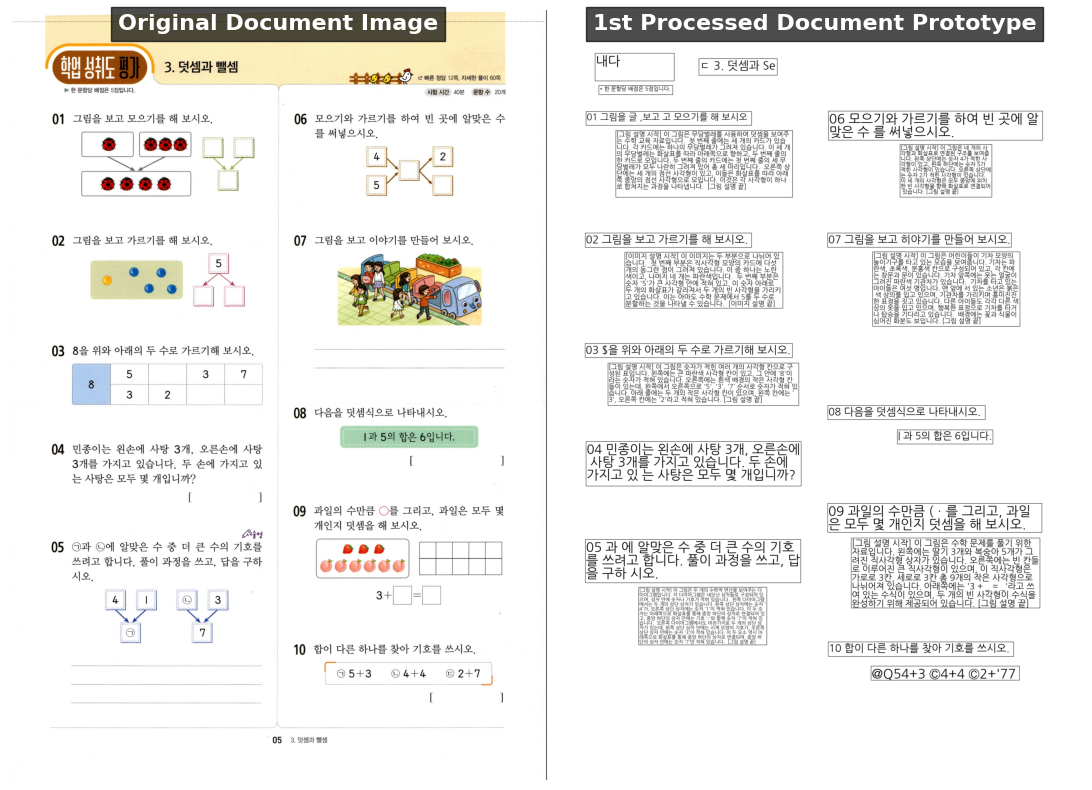

2025-06-10 09:20:56.762 | INFO     | __main__:<cell line: 0>:150 - ✅ 최종 비교 시각화 완료!


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

# (Colab 환경에서만 필요)
!apt-get install -y fonts-nanum

# ============================================
# 📐 캔버스 생성 (원본 이미지와 동일 크기, 흰 배경)
# ============================================

logger.info("📐 캔버스 생성 시작...")

canvas_height, canvas_width = img.shape[:2]
canvas = np.ones((canvas_height, canvas_width, 3), dtype=np.uint8) * 255  # 흰색 배경

logger.info("✅ 캔버스 생성 완료!")

# ============================================
# 🖼️ OCR 및 API 바운딩 박스 그리기 (OpenCV)
# ============================================

logger.info("🖼️ OCR 및 API 바운딩 박스 그리기 시작...")

for result in ocr_results + api_results:
    x1, y1, x2, y2 = result['coordinates']
    cv2.rectangle(canvas, (x1, y1), (x2, y2), (0, 0, 0), 2)

logger.info("✅ OCR 및 API 바운딩 박스 그리기 완료!")

# ============================================
# 🖼️ OpenCV → PIL 변환 (한글 및 줄바꿈용)
# ============================================

logger.info("🖼️ OpenCV → PIL 변환 시작...")

canvas_pil = Image.fromarray(cv2.cvtColor(canvas, cv2.COLOR_BGR2RGB))
draw = ImageDraw.Draw(canvas_pil)

logger.info("✅ OpenCV → PIL 변환 완료!")

# ============================================
# 🖋️ 한글 폰트 불러오기 (경로는 환경에 맞게 수정)
# ============================================

font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"  # Colab 예시

# ============================================
# 🔧 유틸 함수: 픽셀 기반 줄바꿈
# ============================================

def wrap_text_to_box(text, font, box_width):
    wrapped_lines = []
    current_line = ''
    for char in text:
        test_line = current_line + char
        if font.getlength(test_line) <= box_width - 10:  # 좌우 여백 고려
            current_line = test_line
        else:
            wrapped_lines.append(current_line)
            current_line = char
    if current_line:
        wrapped_lines.append(current_line)
    return wrapped_lines

def get_scaled_font_and_lines(text, box_width, box_height, font_path):
    max_font_size = 100
    min_font_size = 10

    for font_size in range(max_font_size, min_font_size, -2):
        font = ImageFont.truetype(font_path, font_size)
        lines = wrap_text_to_box(text, font, box_width)
        text_height = len(lines) * font_size

        if text_height <= box_height:
            return font, lines

    # 실패 → 최소 폰트 크기 적용
    font = ImageFont.truetype(font_path, min_font_size)
    lines = wrap_text_to_box(text, font, box_width)
    return font, lines

# ============================================
# 🖊️ OCR 및 API 텍스트 출력 (PIL)
# ============================================

logger.info("🖊️ OCR 및 API 텍스트 출력 시작...")

for result in ocr_results:
    x1, y1, x2, y2 = result['coordinates']
    box_width = x2 - x1
    box_height = y2 - y1
    text = result['text'].replace('\n', ' ')
    font, lines = get_scaled_font_and_lines(text, box_width, box_height, font_path)

    for i, line in enumerate(lines):
        draw.text((x1 + 5, y1 + i * font.size), line, font=font, fill=(0, 0, 0))

for result in api_results:
    x1, y1, x2, y2 = result['coordinates']
    box_width = x2 - x1
    box_height = y2 - y1
    description = result['description'].replace('\n', ' ')
    font, lines = get_scaled_font_and_lines(description, box_width, box_height, font_path)

    for i, line in enumerate(lines):
        draw.text((x1 + 5, y1 + i * font.size), line, font=font, fill=(0, 0, 0))

logger.info("✅ OCR 및 API 텍스트 출력 완료!")

# ============================================
# 🖼️ 원본 이미지 + 최종 캔버스 이미지 좌우 비교 출력 (검정색 구분선 포함, 각 이미지 개별 제목)
# ============================================

logger.info("🖼️ 최종 비교 시각화 시작...")

# 원본 이미지 (OpenCV → RGB)
original_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
canvas_np = np.array(canvas_pil)

# 이미지 높이와 너비
height, width, _ = original_rgb.shape

# 검정색 구분선 생성 (세로 5px)
gap_width = 5
black_line = np.zeros((height, gap_width, 3), dtype=np.uint8)

# 두 이미지 가로로 이어붙이기: [원본 | 검정줄 | 처리본]
combined_image = np.hstack((original_rgb, black_line, canvas_np))

# 최종 출력
plt.figure(figsize=(20, 10))
plt.imshow(combined_image)
plt.axis('off')

# 중앙 위치 계산
mid_x = width + gap_width // 2

# 왼쪽 이미지 제목
plt.text(width // 2, 30, 'Original Document Image', fontsize=16, fontweight='bold',
         ha='center', va='top', color='white', bbox=dict(facecolor='black', alpha=0.7, pad=5))

# 오른쪽 이미지 제목
plt.text(width + gap_width + width // 2, 30, '1st Processed Document Prototype', fontsize=16, fontweight='bold',
         ha='center', va='top', color='white', bbox=dict(facecolor='black', alpha=0.7, pad=5))

plt.show()

logger.info("✅ 최종 비교 시각화 완료!")


## 파이선 딕셔너리 JSON 변환 컴포넌트

향후 구현 예정